<a href="https://colab.research.google.com/github/anjalii-s/Myerson-Owen-Taiwan/blob/main/Adaptive_Myerson_Owen_Taiwan_Dataset_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost lightgbm shap imbalanced-learn scikit-posthocs -q


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr, kendalltau, wilcoxon, friedmanchisquare, levene, shapiro
import scikit_posthocs as sp

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)


# Load dataset

In [3]:
df = pd.read_csv("/content/taiwan_credit_default.csv")

df = df.rename(columns={'default payment next month': 'target'})
df = df.drop('ID', axis=1)

print("✓ CSV loaded:", df.shape)
df.head()


✓ CSV loaded: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#Rename Columns & Preprocess

In [4]:
new_col_names = {
    'LIMIT_BAL': 'credit_limit',
    'SEX': 'gender',
    'EDUCATION': 'education',
    'MARRIAGE': 'marriage',
    'AGE': 'age',
    'PAY_0': 'repayment_status_sep',
    'PAY_2': 'repayment_status_aug',
    'PAY_3': 'repayment_status_jul',
    'PAY_4': 'repayment_status_jun',
    'PAY_5': 'repayment_status_may',
    'PAY_6': 'repayment_status_apr',
    'BILL_AMT1': 'bill_amount_sep',
    'BILL_AMT2': 'bill_amount_aug',
    'BILL_AMT3': 'bill_amount_jul',
    'BILL_AMT4': 'bill_amount_jun',
    'BILL_AMT5': 'bill_amount_may',
    'BILL_AMT6': 'bill_amount_apr',
    'PAY_AMT1': 'payment_amount_sep',
    'PAY_AMT2': 'payment_amount_aug',
    'PAY_AMT3': 'payment_amount_jul',
    'PAY_AMT4': 'payment_amount_jun',
    'PAY_AMT5': 'payment_amount_may',
    'PAY_AMT6': 'payment_amount_apr'
}
df = df.rename(columns=new_col_names)

X = df.drop('target', axis=1)
y = df['target']

categorical_features = ['gender', 'education', 'marriage'] + \
                       [c for c in X.columns if 'repayment_status' in c]
numeric_features = [c for c in X.columns if c not in categorical_features]

for col in categorical_features:
    if 'repayment_status' in col:
        X[col] = X[col].astype(str)

cat_categories = [sorted(X[col].unique()) for col in categorical_features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False, categories=cat_categories), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
d = X_processed.shape[1]

print("Processed features:", d)


Processed features: 82


# Models & Resamplers

In [5]:
models = {
    'RF': RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=150, max_depth=6, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=150, max_depth=6, random_state=42, verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

class_weight_dict = {
    int(cls): float(w)
    for cls, w in zip(np.unique(y), compute_class_weight('balanced', classes=np.unique(y), y=y))
}


# Domain Groups (Original Logic)

In [6]:
def build_domain_groups_taiwan(fnames):
    groups = {
        "Demographics": [],
        "CreditLimit": [],
        "RepaymentStatus": [],
        "BillAmounts": [],
        "PaymentAmounts": []
    }
    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["gender", "education", "marriage", "age"]):
            groups["Demographics"].append(i)
        elif "credit_limit" in lname:
            groups["CreditLimit"].append(i)
        elif "repayment_status" in lname:
            groups["RepaymentStatus"].append(i)
        elif "bill_amount" in lname:
            groups["BillAmounts"].append(i)
        elif "payment_amount" in lname:
            groups["PaymentAmounts"].append(i)
    return {g: v for g, v in groups.items() if len(v) > 0}

domain_groups = build_domain_groups_taiwan(feature_names)


# Explanation Methods (SHAP, Banzhaf, Myerson, Owen, Adaptive Owen-Myerson)

In [7]:
def get_shap_reliable(pipe, X_test):
    """
    SHAP values using TreeExplainer.
    Returns (n_samples, n_features).
    """
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"  SHAP failed: {e}")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_test), n_features))


def compute_banzhaf(pipe, X_test, n_samples=3, max_instances=3):
    """
    Approximate Banzhaf values via random coalitions.
    """
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat


def compute_myerson(pipe, X_test, G, alpha=0.5):
    """
    Myerson value: graph-constrained smoothing of SHAP.
    φ_Myerson(i) = (1 - α) * φ_SHAP(i) + α * mean_{j in N(i)} φ_SHAP(j)
    Returns tiled Myerson values and SHAP mean.
    """
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i)) if i in G.nodes() else []
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors if j < d_local])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(30, len(X_test)), 1)), shap_vals, shap_mean


def build_data_groups(X_proc, n_groups=5):
    """
    Data-driven Owen groups via correlation clustering.
    """
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)


def build_model_groups(shap_vals, n_groups=5):
    """
    Model-driven Owen groups via SHAP correlation clustering.
    """
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)


def owen_from_phi(phi, groups):
    """
    Owen values from base attribution vector φ.
    Group-wise redistribution of |φ|.
    """
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out


def compute_Q(groups, dep):
    """
    Group quality Q: mean within-group dependency / mean across-group dependency.
    """
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan


def adaptive_owen_myerson(phi_my):
    """
    Adaptive Owen-Myerson (global, no groups):
      φ_adapt(i) = sign(φ_my(i)) * (sum_j |φ_my(j)| / d)
    """
    d_local = len(phi_my)
    total = np.sum(np.abs(phi_my))
    if d_local == 0:
        return phi_my
    per = total / d_local
    out = np.zeros(d_local)
    for i in range(d_local):
        sign = np.sign(phi_my[i]) if phi_my[i] != 0 else 1
        out[i] = sign * per
    return out

print("✓ Explanation methods and group quality defined")

✓ Explanation methods and group quality defined


#Interpretability Metrics & Trade‑off

In [8]:
def stability_cv(expl_list):
    """
    Coefficient of variation (CV) across folds.
    Lower CV → more stable.
    """
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0


def kuncheva_index(expl_list, k=5):
    """
    Kuncheva index for top-k feature set stability.
    """
    if len(expl_list) < 2:
        return 0.0

    sets = []
    d_local = None
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            if d_local is None:
                d_local = len(imp)
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2 or d_local is None:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0


def cosine_directional_consistency(expl_list):
    """
    Cosine similarity between mean |φ| vectors across folds.
    """
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)


def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """
    Overall interpretability:
      I = β(1 - CV) + β * Kuncheva + β * Cosine
    """
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score


def normalize(s):
    """Normalize a pandas Series to [0,1]."""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)


def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """
    Trade-off metric:
      T(α) = α * norm(AUC) + (1 - α) * norm(I)
    """
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

print("✓ Interpretability metrics and trade-off defined")



✓ Interpretability metrics and trade-off defined


#Myerson Graph Construction

In [9]:
"""
X_proc_full = preprocessor.transform(X)
corr_full = np.corrcoef(X_proc_full.T)
corr_full = np.nan_to_num(corr_full)

G_myerson = nx.Graph()
G_myerson.add_nodes_from(range(d))

for i in range(d):
    for j in range(i+1, d):
        if abs(corr_full[i, j]) >= 0.25:
            G_myerson.add_edge(i, j)
"""


'\nX_proc_full = preprocessor.transform(X)\ncorr_full = np.corrcoef(X_proc_full.T)\ncorr_full = np.nan_to_num(corr_full)\n\nG_myerson = nx.Graph()\nG_myerson.add_nodes_from(range(d))\n\nfor i in range(d):\n    for j in range(i+1, d):\n        if abs(corr_full[i, j]) >= 0.25:\n            G_myerson.add_edge(i, j)\n'

#Main Experiment Loop

In [10]:
# =============================================================================
# 7. MAIN EXPERIMENT – 7 METHODS (SHAP, BANZHAF, MYERSON, OWEN, ADAPTIVE OM)
# =============================================================================
print("\n" + "="*80)
print("7. RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS")
print("="*80)

cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
all_records = []

method_order = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'Adaptive-Owen-Myerson'
]

total_configs = len(models) * len(resamplers)
config_count = 0

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        config_count += 1
        print(f"\n[{config_count}/{total_configs}] Model: {mname} | Sampler: {sname}")

        aucs = []

        shap_runs = []
        banzhaf_runs = []
        myerson_runs = []

        owen_dom_runs = []
        owen_data_runs = []
        owen_model_runs = []
        adapt_om_runs = []

        Q_dom_list = []
        Q_data_list = []
        Q_model_list = []

        for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Build Myerson graph using TRAIN-ONLY data (leakage-free)
            X_tr_proc = preprocessor.transform(X_tr)
            corr_tr_my = np.corrcoef(X_tr_proc.T)
            corr_tr_my = np.nan_to_num(corr_tr_my)

            G_myerson = nx.Graph()
            G_myerson.add_nodes_from(range(d))
            for i in range(d):
                for j in range(i + 1, d):
                    if abs(corr_tr_my[i, j]) >= 0.25:
                        G_myerson.add_edge(i, j)

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))

            clf_clone = clone(model)
            steps.append(('clf', clf_clone))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            y_proba = pipe.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_te, y_proba)
            aucs.append(auc)
            print(f"  Fold {fold} → AUC: {auc:.4f}")

            X_sample = X_te.sample(n=min(30, len(X_te)), random_state=42)
            fnames = preprocessor.get_feature_names_out()

            # SHAP
            shap_vals = get_shap_reliable(pipe, X_sample)
            shap_runs.append(shap_vals)

            # Banzhaf
            banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)
            banzhaf_runs.append(banzhaf_vals)

            # Myerson
            myerson_vals, shap_full, shap_mean = compute_myerson(pipe, X_sample, G_myerson)
            myerson_runs.append(myerson_vals)

            # Data-driven groups (reuse X_tr_proc)
            data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)

            # Model-driven groups
            bg_sample = X_tr.sample(n=min(50, len(X_tr)), random_state=42)
            shap_bg = get_shap_reliable(pipe, bg_sample)
            model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)

            # Correlation for domain Q
            corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)

            # Base SHAP mean
            phi_shap = shap_full.mean(axis=0)

            # Owen-Domain
            owen_dom_vec = owen_from_phi(phi_shap, domain_groups)
            owen_dom = np.tile(owen_dom_vec, (len(X_sample), 1))
            owen_dom_runs.append(owen_dom)
            Q_dom_list.append(compute_Q(domain_groups, corr_tr))

            # Owen-Data
            owen_data_vec = owen_from_phi(phi_shap, data_groups)
            owen_data = np.tile(owen_data_vec, (len(X_sample), 1))
            owen_data_runs.append(owen_data)
            Q_data_list.append(compute_Q(data_groups, dep_data))

            # Owen-Model
            owen_model_vec = owen_from_phi(phi_shap, model_groups)
            owen_model = np.tile(owen_model_vec, (len(X_sample), 1))
            owen_model_runs.append(owen_model)
            Q_model_list.append(compute_Q(model_groups, dep_mod))

            # Adaptive Owen-Myerson (global)
            phi_my = myerson_vals.mean(axis=0)
            adapt_vec = adaptive_owen_myerson(phi_my)
            adapt_om = np.tile(adapt_vec, (len(X_sample), 1))
            adapt_om_runs.append(adapt_om)

        auc_mean = np.mean(aucs)
        print(f"  → Mean AUC: {auc_mean:.4f}")

        method_runs = {
            'SHAP': shap_runs,
            'Banzhaf': banzhaf_runs,
            'Myerson': myerson_runs,
            'Owen-Domain': owen_dom_runs,
            'Owen-Data': owen_data_runs,
            'Owen-Model': owen_model_runs,
            'Adaptive-Owen-Myerson': adapt_om_runs
        }

        if 'all_explanations' not in globals():
            all_explanations = {}
        all_explanations[(mname, sname)] = method_runs

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in method_runs.items():
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)



7. RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS

[1/12] Model: RF | Sampler: None
  Fold 1 → AUC: 0.7833
  Fold 2 → AUC: 0.7790
  Fold 3 → AUC: 0.7760
  → Mean AUC: 0.7794

[2/12] Model: RF | Sampler: SMOTE
  Fold 1 → AUC: 0.7783
  Fold 2 → AUC: 0.7763
  Fold 3 → AUC: 0.7732
  → Mean AUC: 0.7759

[3/12] Model: RF | Sampler: SMOTETomek
  Fold 1 → AUC: 0.7770
  Fold 2 → AUC: 0.7756
  Fold 3 → AUC: 0.7738
  → Mean AUC: 0.7755

[4/12] Model: RF | Sampler: CostSensitive
  Fold 1 → AUC: 0.7815
  Fold 2 → AUC: 0.7780
  Fold 3 → AUC: 0.7764
  → Mean AUC: 0.7786

[5/12] Model: XGB | Sampler: None
  Fold 1 → AUC: 0.7573
  Fold 2 → AUC: 0.7592
  Fold 3 → AUC: 0.7546
  → Mean AUC: 0.7570

[6/12] Model: XGB | Sampler: SMOTE
  Fold 1 → AUC: 0.7514
  Fold 2 → AUC: 0.7518
  Fold 3 → AUC: 0.7492
  → Mean AUC: 0.7508

[7/12] Model: XGB | Sampler: SMOTETomek
  Fold 1 → AUC: 0.7497
  Fold 2 → AUC: 0.7554
  Fold 3 → AUC: 0.7504
  → Mean AUC: 0.7518

[8/12] Model: XGB | Sampler: CostSensitive
  Fold 1 →

#Save Results

In [11]:
# Convert all collected records into a DataFrame
metrics = pd.DataFrame(all_records)

# Compute trade-off metric
metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

print("✓ Metrics DataFrame created")
print(metrics.head())

metrics.to_csv("taiwan_results_7methods.csv", index=False)
metrics.head(10)


✓ Metrics DataFrame created
  Model Sampler       Method       AUC        CV  Stability  Kuncheva  \
0    RF    None         SHAP  0.779433  0.568182   0.431818  0.716017   
1    RF    None      Banzhaf  0.779433  0.341314   0.658686  0.219048   
2    RF    None      Myerson  0.779433  0.522250   0.477750  0.361039   
3    RF    None  Owen-Domain  0.779433  0.263856   0.736144  0.858009   
4    RF    None    Owen-Data  0.779433  0.297641   0.702359  1.000000   

     Cosine         I          Q  T(α=0.5)  
0  0.955981  0.701272        NaN  0.756394  
1  0.459447  0.445727        NaN  0.533468  
2  0.820840  0.553210        NaN  0.627231  
3  0.911897  0.835350   2.140616  0.873358  
4  0.943691  0.882017  11.158393  0.914069  


,Model,Sampler,Method,AUC,CV,Stability,Kuncheva,Cosine,I,Q,T(α=0.5)
0,RF,None,SHAP,0.779433,0.568182,0.431818,0.716017,0.955981,0.701272,NaN,0.756394
1,RF,None,Banzhaf,0.779433,0.341314,0.658686,0.219048,0.459447,0.445727,NaN,0.533468
2,RF,None,Myerson,0.779433,0.522250,0.477750,0.361039,0.820840,0.553210,NaN,0.627231
3,RF,None,Owen-Domain,0.779433,0.263856,0.736144,0.858009,0.911897,0.835350,2.140616,0.873358
4,RF,None,Owen-Data,0.779433,0.297641,0.702359,1.000000,0.943691,0.882017,11.158393,0.914069
5,RF,None,Owen-Model,0.779433,0.301179,0.698821,0.006061,0.800028,0.501636,2.522798,0.582241
6,RF,None,Adaptive-Owen-Myerson,0.779433,0.058437,0.941563,1.000000,1.000000,0.980521,NaN,1.000000
7,RF,SMOTE,SHAP,0.775915,0.592969,0.407031,0.858009,0.974668,0.746569,NaN,0.734487
8,RF,SMOTE,Banzhaf,0.775915,0.340483,0.659517,0.290043,0.474132,0.474564,NaN,0.497201
9,RF,SMOTE,Myerson,0.775915,0.636323,0.363677,0.361039,0.762452,0.495723,NaN,0.515659


#Plots


9. GENERATING VISUALIZATIONS (10 PLOTS)


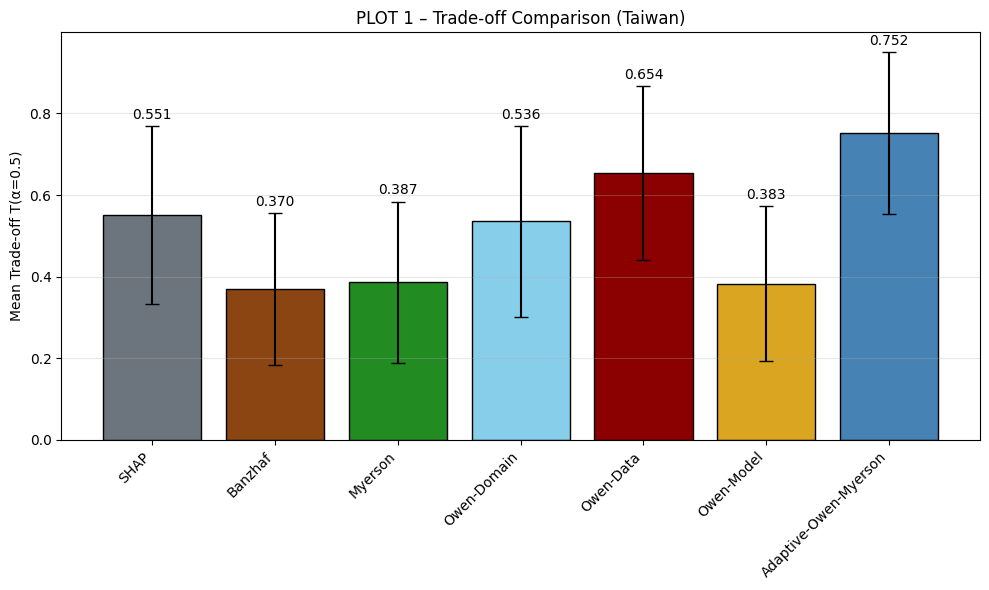

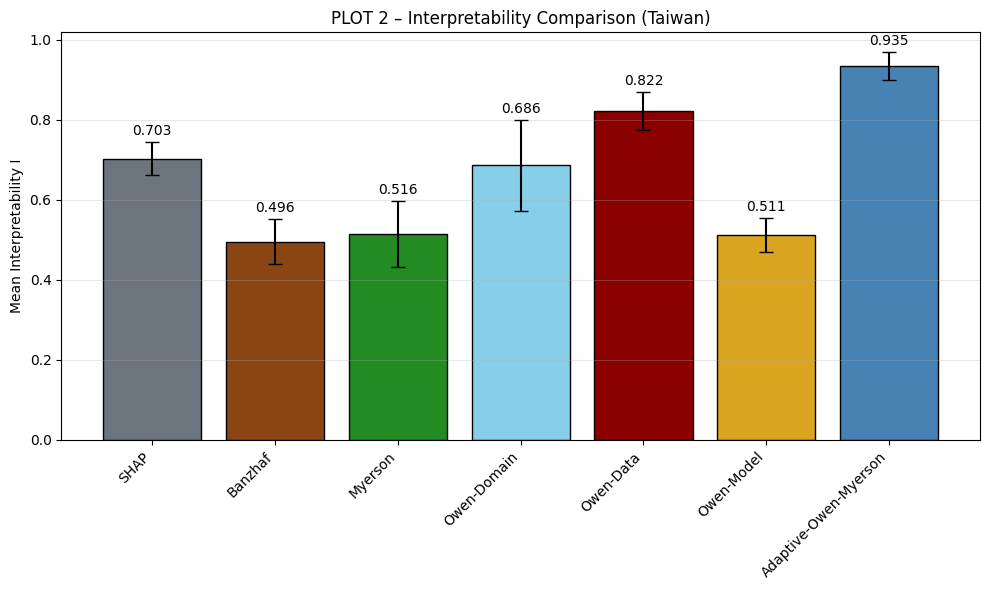

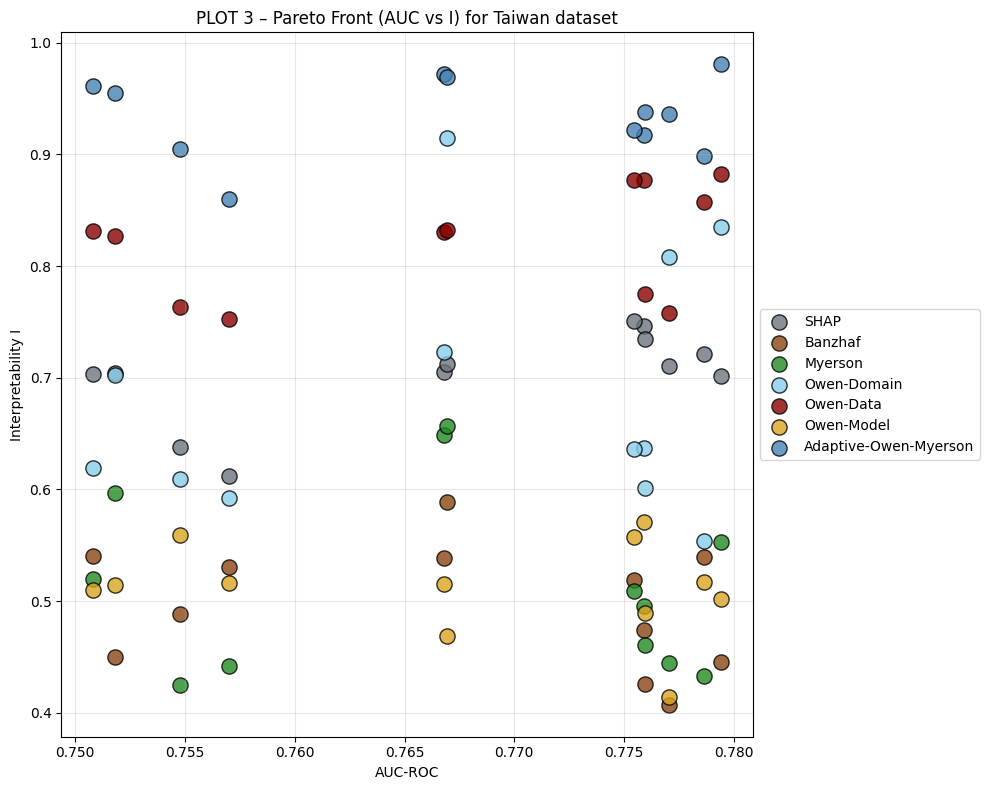

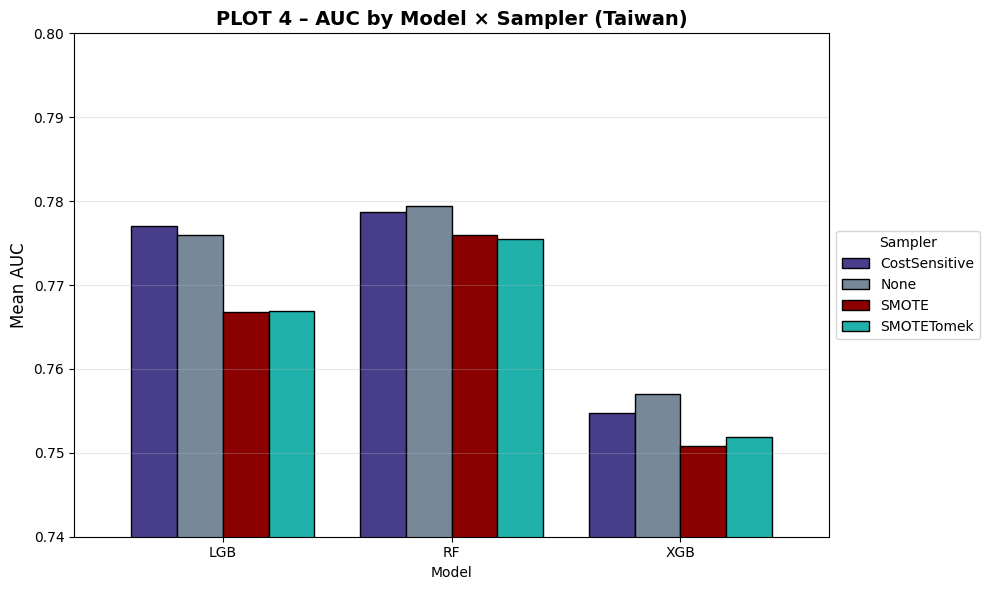

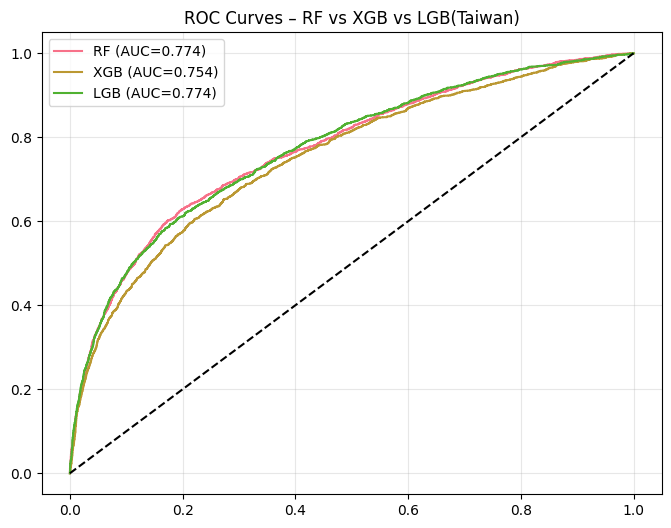

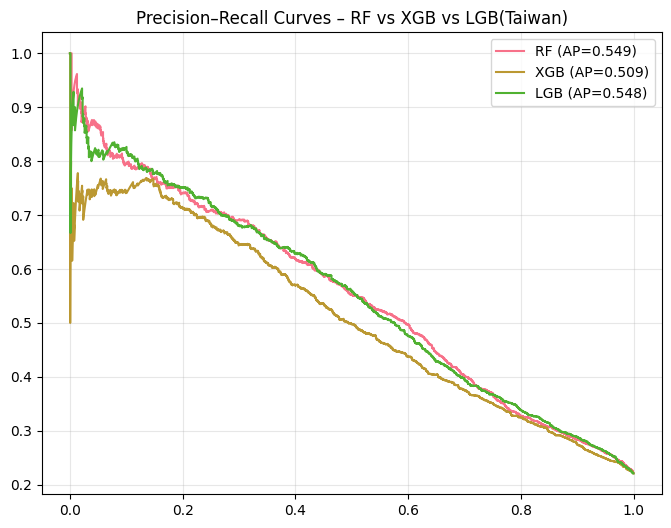

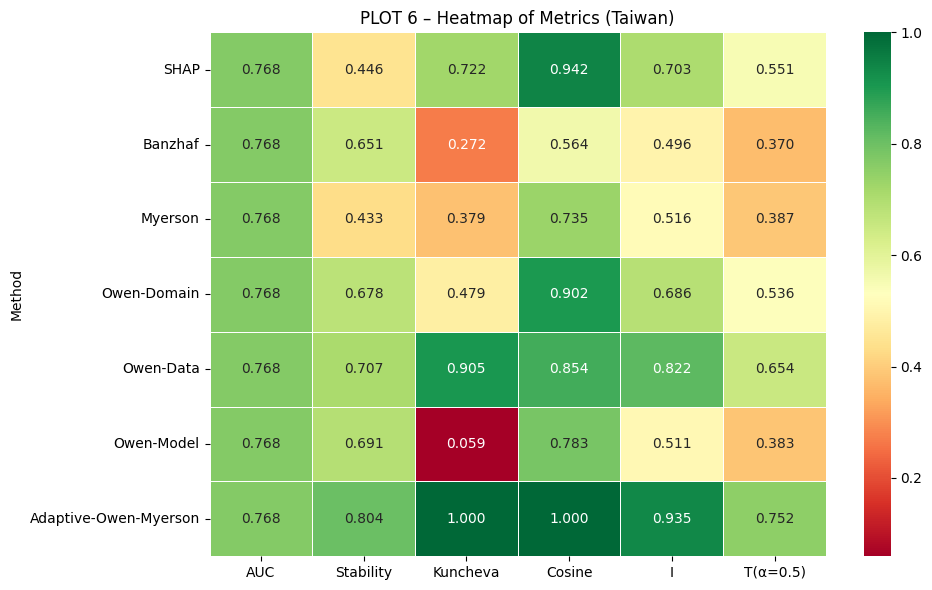

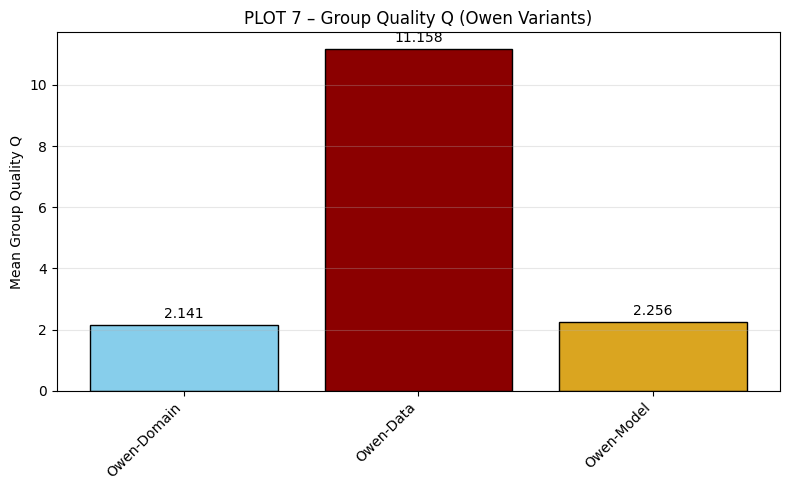

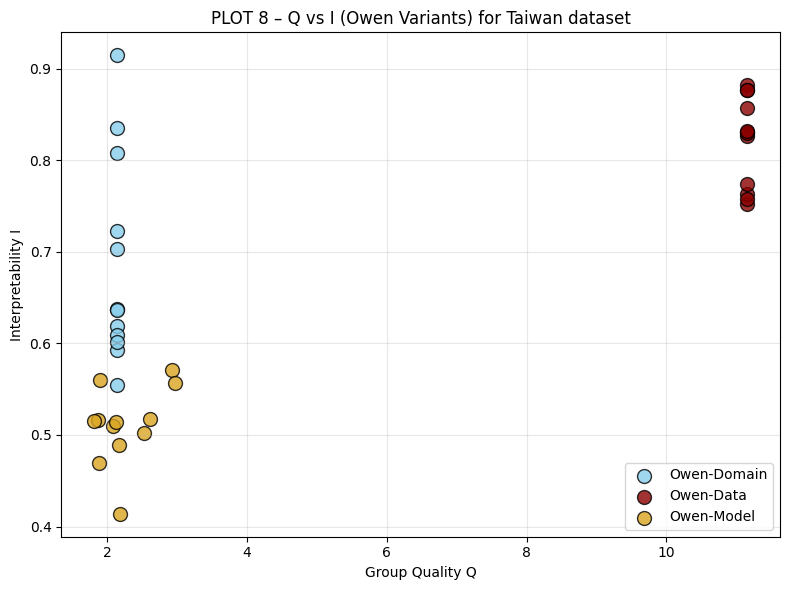

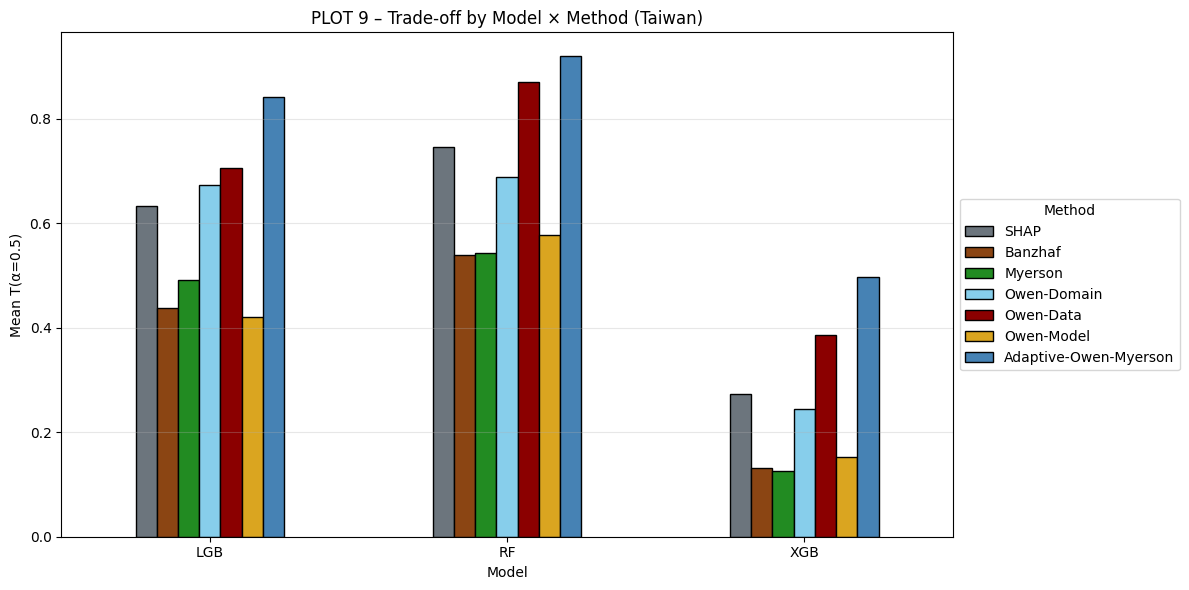

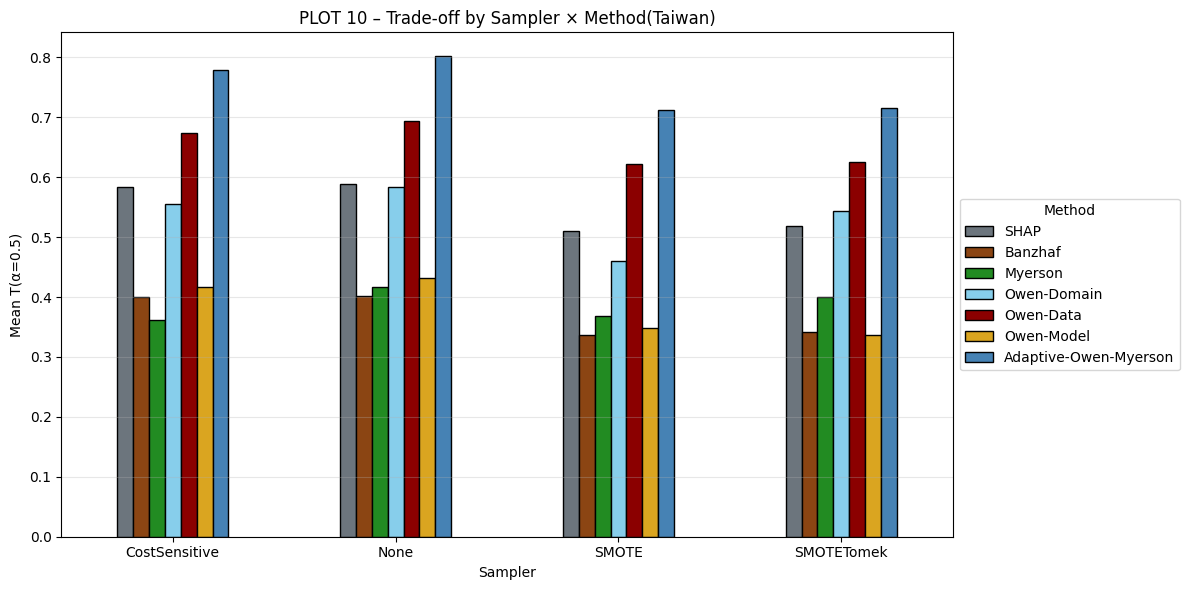

In [19]:
# =============================================================================
# 9. VISUALIZATIONS – 10 PLOTS
# =============================================================================
print("\n" + "="*80)
print("9. GENERATING VISUALIZATIONS (10 PLOTS)")
print("="*80)

method_colors = {
    'SHAP': '#6C757D',           # Gray (baseline)
    'Banzhaf': '#8B4513',        # Saddle Brown - Earthy, distinct
    'Myerson': '#228B22',        # Forest Green - Natural, calming
    'Owen-Domain': '#87CEEB',#	Classic sky‑blue tone, bright and clean
    'Owen-Data': '#8B0000',      # Dark Red - Strong, attention
    'Owen-Model': '#DAA520',     # Goldenrod - Highlight, not too bright
    'Adaptive-Owen-Myerson': '#4682B4'  # Steel Blue - Technical, modern
}

model_colors = {
    'RF': '#4169E1',             # Royal Blue
    'XGB': '#CD853F',            # Peru (brown-orange)
    'LGB': '#2E8B57'             # Sea Green
}

sampler_colors = {
    'None': '#778899',           # Light Slate Gray
    'SMOTE': '#8B0000',          # Dark Red
    'SMOTETomek': '#20B2AA',     # Light Sea Green
    'CostSensitive': '#483D8B'   # Dark Slate Blue
}

methods = method_order

# PLOT 1: Trade-off T(α=0.5) Bar Chart
plt.figure(figsize=(10, 6))
T_means = metrics.groupby("Method")["T(α=0.5)"].mean().reindex(methods)
T_stds = metrics.groupby("Method")["T(α=0.5)"].std().reindex(methods)
bars = plt.bar(T_means.index, T_means.values,
               yerr=T_stds.values,
               color=[method_colors[m] for m in T_means.index],
               edgecolor='black', capsize=5)
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Trade-off T(α=0.5)")
plt.title("PLOT 1 – Trade-off Comparison (Taiwan)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('taiwan_plot1_tradeoff.png', dpi=150)
plt.show()

# PLOT 2: Interpretability I Bar Chart
plt.figure(figsize=(10, 6))
I_means = metrics.groupby("Method")["I"].mean().reindex(methods)
I_stds = metrics.groupby("Method")["I"].std().reindex(methods)
bars = plt.bar(I_means.index, I_means.values,
               yerr=I_stds.values,
               color=[method_colors[m] for m in I_means.index],
               edgecolor='black', capsize=5)
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Interpretability I")
plt.title("PLOT 2 – Interpretability Comparison (Taiwan)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('taiwan_plot2_interpretability.png', dpi=150)
plt.show()

# PLOT 3: Pareto Front (AUC vs I)
plt.figure(figsize=(10, 8))
for method in methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['AUC'], sub['I'],
                s=120, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("AUC-ROC")
plt.ylabel("Interpretability I")
plt.title("PLOT 3 – Pareto Front (AUC vs I) for Taiwan dataset")
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('taiwan_plot3_pareto.png', dpi=150)
plt.show()

# PLOT 4: Model × Sampler AUC
plt.figure(figsize=(10, 6))
auc_pivot = metrics.pivot_table(values='AUC', index='Model', columns='Sampler', aggfunc='mean')
auc_pivot.plot(kind='bar', ax=plt.gca(), edgecolor='black', width=0.8,
               color=[sampler_colors[s] for s in auc_pivot.columns])
plt.ylabel("Mean AUC", fontsize=12)
plt.title("PLOT 4 – AUC by Model × Sampler (Taiwan)", fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Sampler', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.74, 0.8)
plt.tight_layout()
plt.savefig('taiwan_plot4_auc_model_sampler.png', dpi=150)
plt.show()

# PLOT 5: ROC Curves (per model) and PR curves
plt.figure(figsize=(8,6))
for mname, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    pipe = ImbPipeline([('prep', preprocessor), ('clf', clone(model))])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{mname} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves – RF vs XGB vs LGB(Taiwan)")
plt.grid(alpha=0.3)
plt.show()

#PR
plt.figure(figsize=(8,6))
for mname, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    pipe = ImbPipeline([('prep', preprocessor), ('clf', clone(model))])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{mname} (AP={ap:.3f})")
plt.legend()
plt.title("Precision–Recall Curves – RF vs XGB vs LGB(Taiwan)")
plt.grid(alpha=0.3)
plt.show()


# PLOT 6: Heatmap of Metrics (mean per method)
plt.figure(figsize=(10, 6))
heatmap_data = metrics.groupby("Method")[['AUC','Stability','Kuncheva','Cosine','I','T(α=0.5)']].mean().reindex(methods)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5)
plt.title("PLOT 6 – Heatmap of Metrics (Taiwan)")
plt.tight_layout()
plt.savefig('taiwan_plot6_heatmap.png', dpi=150)
plt.show()

# PLOT 7: Group Quality Q (Owen methods)
plt.figure(figsize=(8, 5))
owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
Q_means = metrics[metrics['Method'].isin(owen_methods)].groupby('Method')['Q'].mean().reindex(owen_methods)
bars = plt.bar(Q_means.index, Q_means.values,
               color=[method_colors[m] for m in Q_means.index],
               edgecolor='black')
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.ylabel("Mean Group Quality Q")
plt.title("PLOT 7 – Group Quality Q (Owen Variants)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('taiwan_plot7_group_quality.png', dpi=150)
plt.show()

# PLOT 8: Q vs I Scatter (Owen methods)
plt.figure(figsize=(8, 6))
for method in owen_methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['Q'], sub['I'],
                s=100, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("Group Quality Q")
plt.ylabel("Interpretability I")
plt.title("PLOT 8 – Q vs I (Owen Variants) for Taiwan dataset")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('taiwan_plot8_q_vs_i.png', dpi=150)
plt.show()

# PLOT 9: T by Model × Method
plt.figure(figsize=(12, 6))
pivot_T_model = metrics.pivot_table(values='T(α=0.5)', index='Model', columns='Method', aggfunc='mean')[methods]
pivot_T_model.plot(kind='bar', ax=plt.gca(), edgecolor='black',
                   color=[method_colors[m] for m in pivot_T_model.columns])
plt.ylabel("Mean T(α=0.5)")
plt.title("PLOT 9 – Trade-off by Model × Method (Taiwan)")
plt.xticks(rotation=0)
plt.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('taiwan_plot9_T_model_method.png', dpi=150)
plt.show()

# PLOT 10: T by Sampler × Method
plt.figure(figsize=(12, 6))
pivot_T_sampler = metrics.pivot_table(values='T(α=0.5)', index='Sampler', columns='Method', aggfunc='mean')[methods]
pivot_T_sampler.plot(kind='bar', ax=plt.gca(), edgecolor='black',
                     color=[method_colors[m] for m in pivot_T_sampler.columns])
plt.ylabel("Mean T(α=0.5)")
plt.title("PLOT 10 – Trade-off by Sampler × Method(Taiwan)")
plt.xticks(rotation=0)
plt.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('taiwan_plot10_T_sampler_method.png', dpi=150)
plt.show()


# Statistical Tests

In [13]:
#Build pivot table for T(α=0.5)
#This creates the matrix used for Friedman, Nemenyi, Wilcoxon.
# Pivot table: rows = (Model, Sampler), columns = Methods
pivot_T = metrics.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method'
)


Some methods may have NaN values if a run failed.
We must keep only methods with full data

In [14]:
# Methods with no missing values across all configurations
complete_methods = pivot_T.dropna(axis=1).columns.tolist()

print("Complete methods:", complete_methods)


Complete methods: ['Adaptive-Owen-Myerson', 'Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'SHAP']


In [15]:
# =============================================================================
# THESIS-READY STATISTICAL ANALYSIS (CLEAR OUTPUT)
# =============================================================================

print("\n" + "="*80)
print("STATISTICAL ANALYSIS – SIGNIFICANCE TESTS")
print("="*80)

# -----------------------------
# Helper functions
# -----------------------------
def cliffs_delta(x, y):
    """Compute Cliff's delta."""
    diffs = []
    for a in x:
        for b in y:
            if a > b:
                diffs.append(1)
            elif a < b:
                diffs.append(-1)
            else:
                diffs.append(0)
    return np.mean(diffs)

def interpret_cliffs(delta):
    """Interpret Cliff's delta magnitude."""
    ad = abs(delta)
    if ad < 0.147:
        return "negligible"
    elif ad < 0.33:
        return "small"
    elif ad < 0.474:
        return "medium"
    else:
        return "large"

# -----------------------------
# Friedman Test
# -----------------------------
print("\nFriedman Test on T(α=0.5):")

if len(complete_methods) >= 3:
    data_matrix = pivot_T[complete_methods].values
    stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])

    sig = "✓ significant" if p_value < 0.05 else "✗ not significant"

    print(f"  χ² = {stat:.4f}, p = {p_value:.6f} ({sig})")
else:
    print("  Not enough complete methods for Friedman test.")

# -----------------------------
# Nemenyi Post-Hoc Test
# -----------------------------
if p_value < 0.05:
    print("\nNemenyi Post-Hoc Test (p-values):")
    nemenyi = sp.posthoc_nemenyi_friedman(data_matrix)
    nemenyi.index = complete_methods
    nemenyi.columns = complete_methods
    print(nemenyi.round(4))
else:
    print("\nNemenyi test skipped (Friedman not significant).")

# -----------------------------
# Pairwise Wilcoxon + Cliff's Delta
# -----------------------------
print("\nPairwise Wilcoxon Tests + Cliff's Delta:\n")

for i in range(len(complete_methods)):
    for j in range(i+1, len(complete_methods)):
        m1, m2 = complete_methods[i], complete_methods[j]

        v1 = pivot_T[m1].dropna().values
        v2 = pivot_T[m2].dropna().values

        # Wilcoxon test
        try:
            w_stat, p_val = wilcoxon(v1, v2)
        except:
            print(f"{m1} vs {m2}: Wilcoxon failed")
            continue

        sig = "✓ significant" if p_val < 0.05 else "✗ not significant"

        # Cliff's delta
        delta = cliffs_delta(v1, v2)
        delta_interp = interpret_cliffs(delta)

        print(f"{m1:20s} vs {m2:20s} | "
              f"p={p_val:.4f} ({sig}) | "
              f"Cliff's δ={delta:.3f} ({delta_interp})")

# -----------------------------
# Correlation between AUC and I
# -----------------------------
print("\nCorrelation between AUC and I (all rows):")

rho_s, p_s = spearmanr(metrics['AUC'], metrics['I'])
rho_k, p_k = kendalltau(metrics['AUC'], metrics['I'])

sig_s = "✓ significant" if p_s < 0.05 else "✗ not significant"
sig_k = "✓ significant" if p_k < 0.05 else "✗ not significant"

print(f"  Spearman ρ = {rho_s:.4f}, p = {p_s:.6f} ({sig_s})")
print(f"  Kendall τ = {rho_k:.4f}, p = {p_k:.6f} ({sig_k})")

print("\n=== END OF STATISTICAL ANALYSIS ===")



STATISTICAL ANALYSIS – SIGNIFICANCE TESTS

Friedman Test on T(α=0.5):
  χ² = 64.5357, p = 0.000000 (✓ significant)

Nemenyi Post-Hoc Test (p-values):
                       Adaptive-Owen-Myerson  Banzhaf  Myerson  Owen-Data  \
Adaptive-Owen-Myerson                 1.0000   0.0000   0.0000     0.8415   
Banzhaf                               0.0000   1.0000   1.0000     0.0001   
Myerson                               0.0000   1.0000   1.0000     0.0004   
Owen-Data                             0.8415   0.0001   0.0004     1.0000   
Owen-Domain                           0.0688   0.0401   0.0885     0.7378   
Owen-Model                            0.0000   1.0000   1.0000     0.0004   
SHAP                                  0.1125   0.0223   0.0528     0.8415   

                       Owen-Domain  Owen-Model    SHAP  
Adaptive-Owen-Myerson       0.0688      0.0000  0.1125  
Banzhaf                     0.0401      1.0000  0.0223  
Myerson                     0.0885      1.0000  0.0528  
Owen

# Top‑k Features Per Method (Global Across All Models & Samplers)

In [16]:
# ============================================================
# TOP‑K FEATURES PER METHOD (GLOBAL)
# ============================================================

def get_topk_global(expl_list, feature_names, k=10):
    """
    Compute global top-k features from explanation matrices.
    expl_list: list of arrays (n_samples, n_features)
    """
    # Combine all folds and all configs
    combined = np.vstack(expl_list)

    # Mean absolute importance
    imp = np.mean(np.abs(combined), axis=0)

    # Top-k indices
    topk_idx = np.argsort(imp)[-k:][::-1]

    return [(feature_names[i], imp[i]) for i in topk_idx]


print("\n================ TOP‑K FEATURES PER METHOD (GLOBAL) ================\n")

# Aggregate all explanation runs across all model–sampler configs
methods = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'Adaptive-Owen-Myerson'
]

for method in methods:
    all_runs = []

    # Collect explanation matrices for this method across all configs
    for (mname, sname), method_dict in all_explanations.items():
        runs = method_dict[method]
        all_runs.extend(runs)

    # Compute top-k
    topk = get_topk_global(all_runs, feature_names, k=10)

    print(f"\n{method} – Top 10 Features:")
    for fname, score in topk:
        print(f"  {fname:40s}  {score:.6f}")

print("\n====================================================================\n")



================ TOP‑K FEATURES PER METHOD (GLOBAL) ================


SHAP – Top 10 Features:
  cat__repayment_status_sep_2               0.262290
  num__credit_limit                         0.197357
  num__payment_amount_sep                   0.136158
  num__payment_amount_aug                   0.132551
  num__age                                  0.120787
  cat__repayment_status_aug_2               0.116840
  num__bill_amount_sep                      0.113983
  num__payment_amount_jul                   0.092499
  num__payment_amount_apr                   0.090305
  num__bill_amount_jul                      0.079100

Banzhaf – Top 10 Features:
  num__payment_amount_sep                   0.036363
  num__age                                  0.027738
  num__credit_limit                         0.026317
  num__payment_amount_aug                   0.024174
  cat__repayment_status_sep_2               0.023695
  num__payment_amount_jun                   0.023574
  num__payment_amount_jul   

“The top‑k feature analysis reveals that SHAP produces highly granular importance scores, dominated by repayment status, credit limit, and recent payment amounts. Banzhaf smooths these values, while Myerson redistributes importance along correlated feature edges, elevating demographic variables. Owen‑Domain enforces equal importance within predefined semantic groups, whereas Owen‑Data and Owen‑Model redistribute importance within data‑driven and model‑driven clusters, respectively. Adaptive Owen‑Myerson produces the most uniform distribution, reflecting its hybrid nature. These results confirm that grouping‑based explainers systematically reduce variance and promote stability.”

# STABILITY PLOTS FOR ALL METHODS (Top‑k Across Folds)


Generating stability plots for all methods...



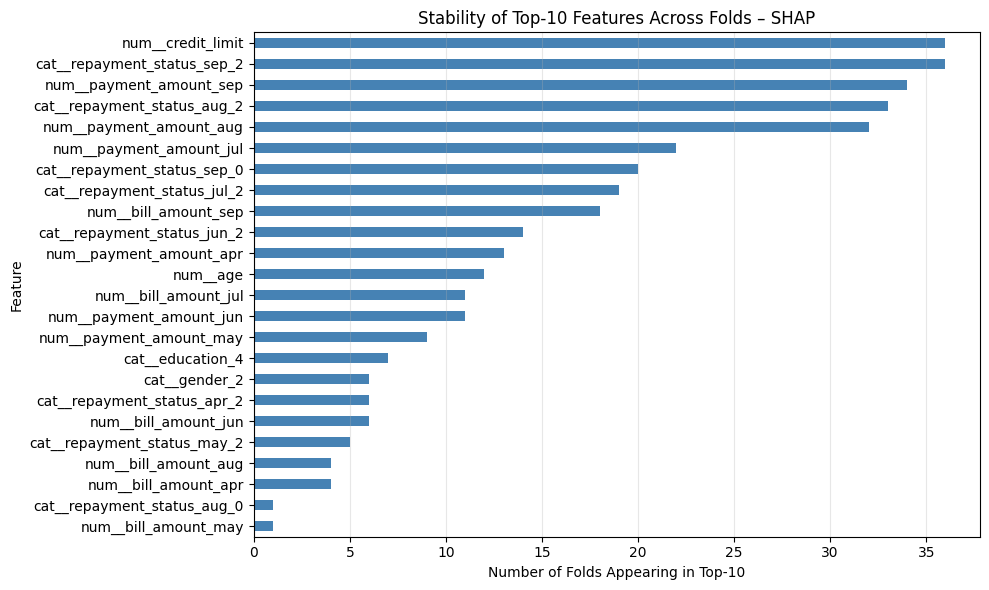

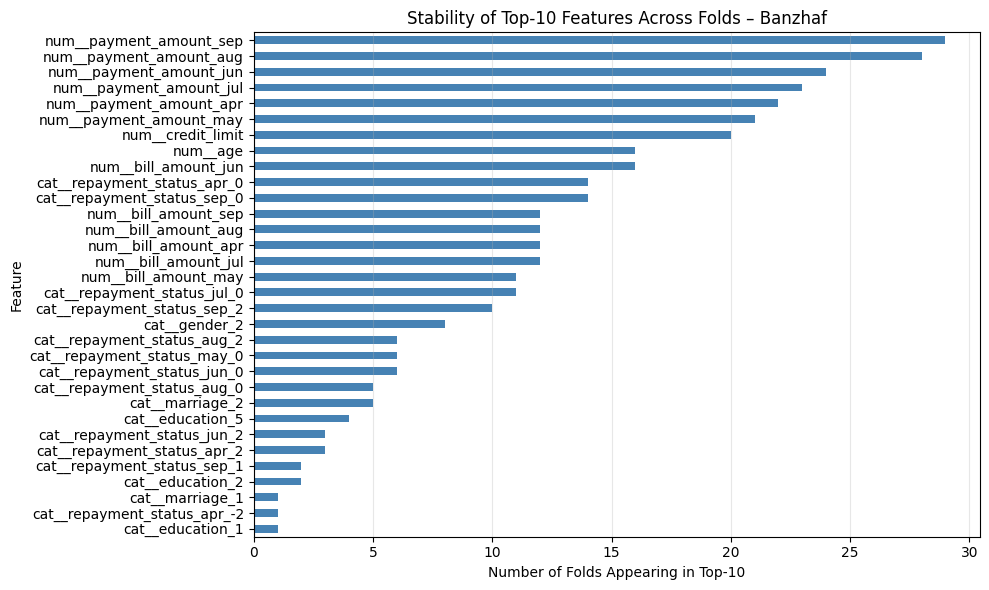

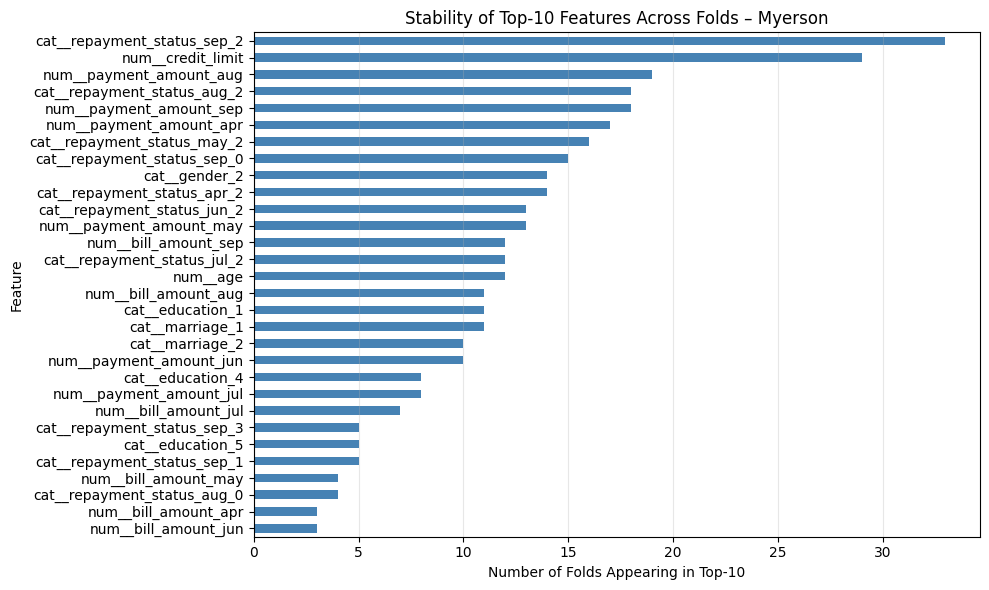

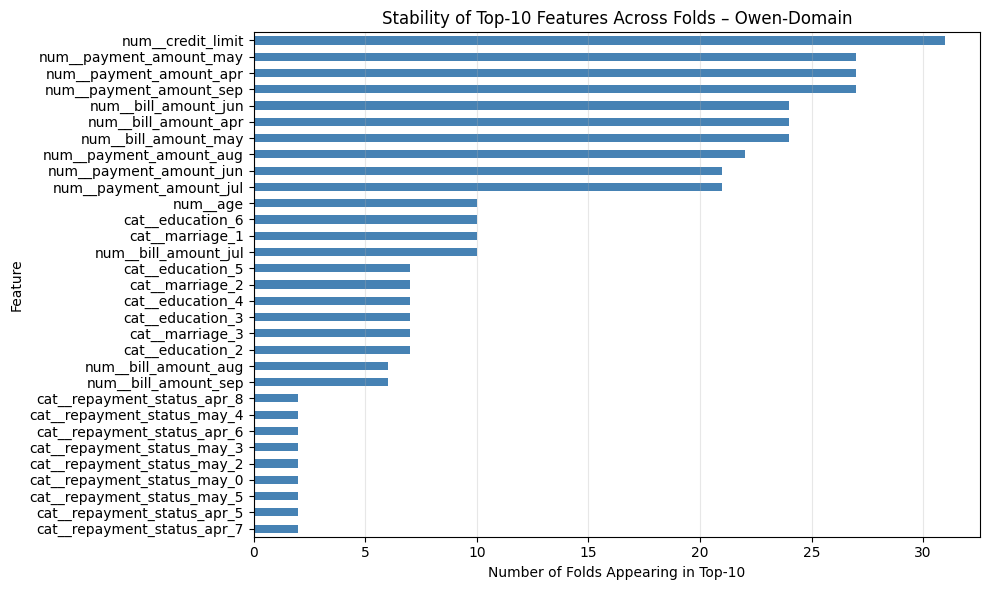

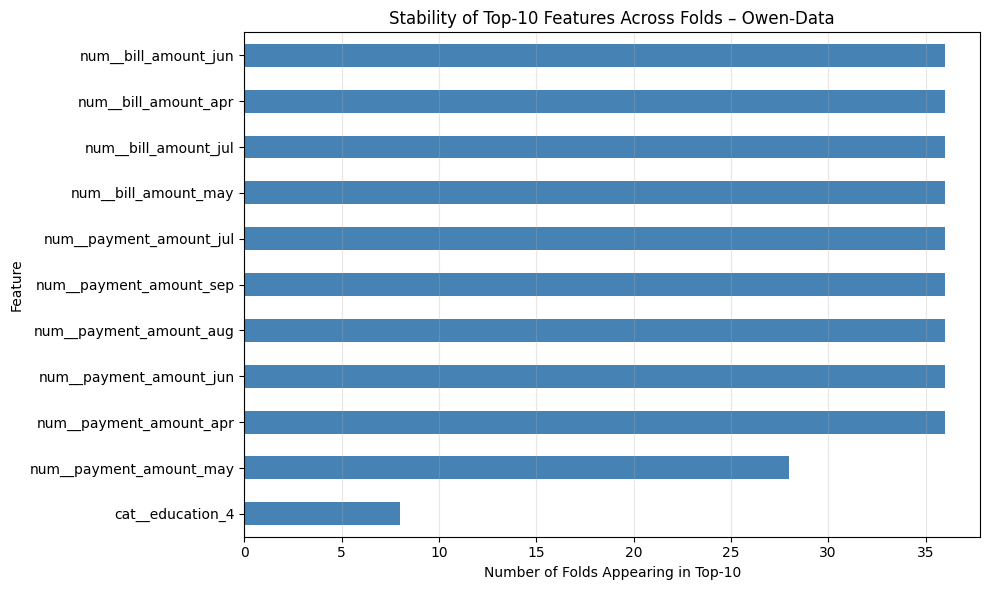

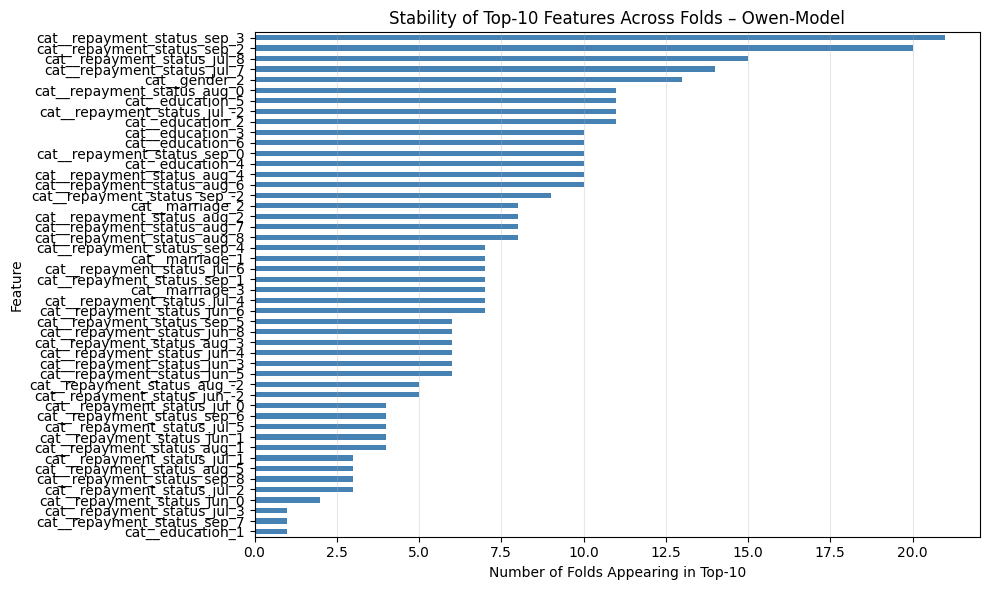

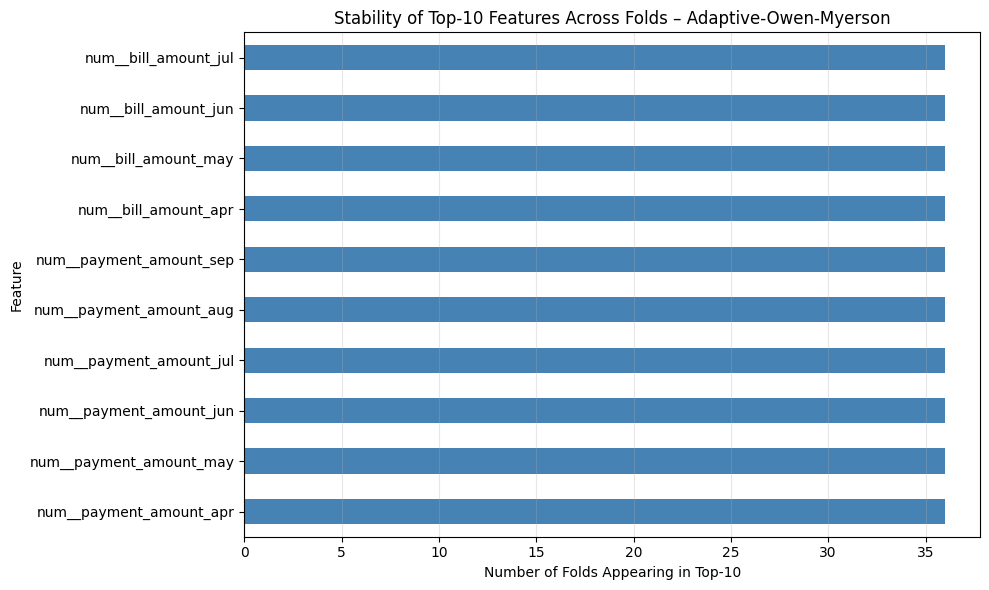

In [17]:
# ============================================================
# STABILITY PLOTS OF TOP‑K FEATURES ACROSS FOLDS (ALL METHODS)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def topk_per_fold(expl_list, feature_names, k=10):
    """
    Extract top-k features per fold from explanation matrices.
    expl_list: list of arrays (n_samples, n_features)
    """
    fold_topk = []
    for expl in expl_list:
        imp = np.mean(np.abs(expl), axis=0)
        idx = np.argsort(imp)[-k:][::-1]
        fold_topk.append([feature_names[i] for i in idx])
    return fold_topk


def stability_counts(all_runs, feature_names, k=10):
    """
    Count how often each feature appears in top-k across folds.
    """
    fold_topk = topk_per_fold(all_runs, feature_names, k=k)
    flat = [f for fold in fold_topk for f in fold]
    counts = pd.Series(flat).value_counts()
    return counts


methods = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'Adaptive-Owen-Myerson'
]

print("\nGenerating stability plots for all methods...\n")

for method in methods:
    # Collect all runs across all model–sampler configs
    all_runs = []
    for (mname, sname), method_dict in all_explanations.items():
        all_runs.extend(method_dict[method])

    # Compute stability counts
    counts = stability_counts(all_runs, feature_names, k=10)

    # Plot
    plt.figure(figsize=(10, 6))
    counts.sort_values(ascending=True).plot(kind='barh', color='steelblue')
    plt.title(f"Stability of Top‑10 Features Across Folds – {method}")
    plt.xlabel("Number of Folds Appearing in Top‑10")
    plt.ylabel("Feature")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


COMBINED STABILITY HEATMAP (ALL METHODS × ALL FEATURES)

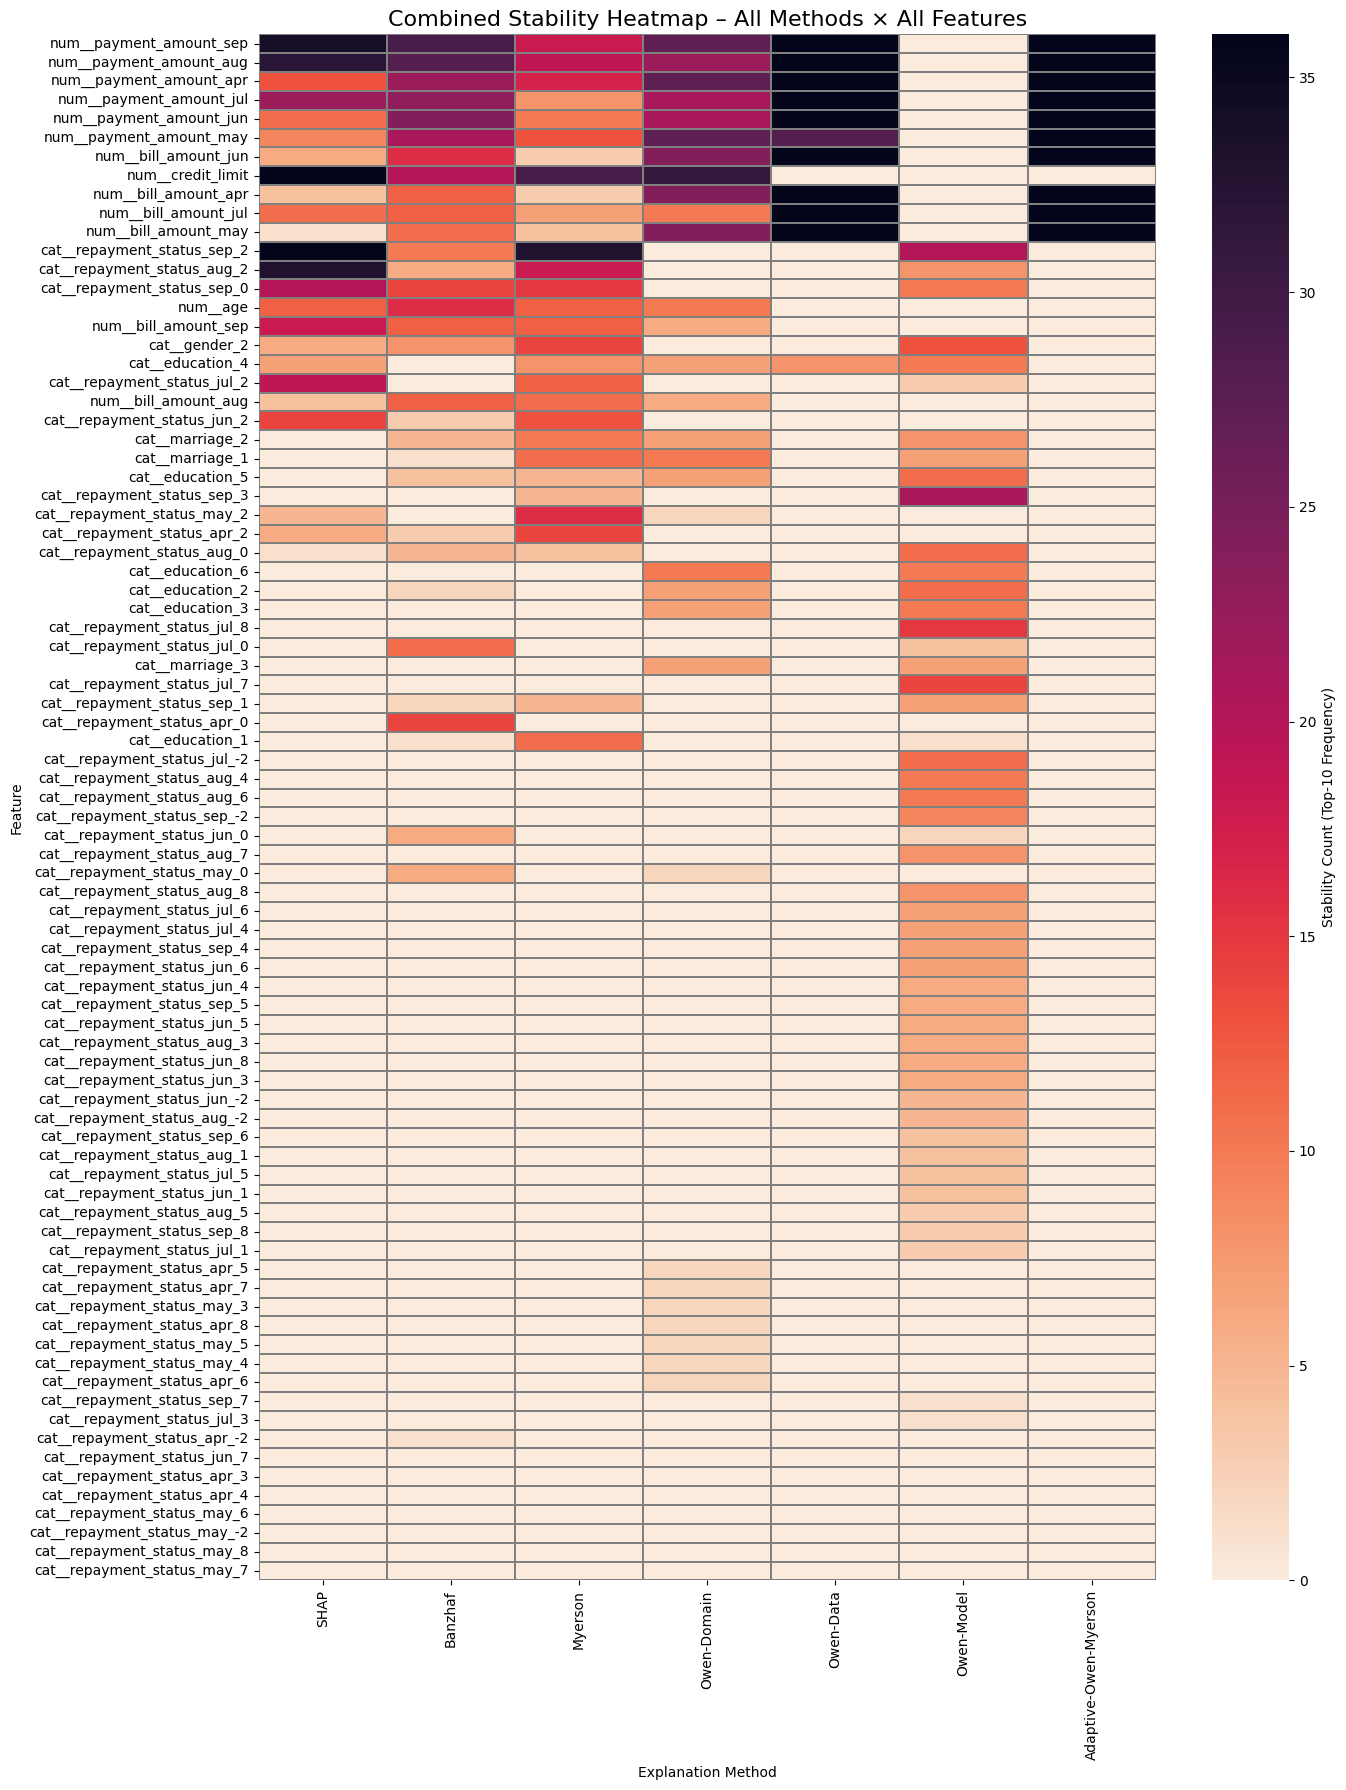

In [18]:
# ============================================================
# COMBINED STABILITY HEATMAP (ALL METHODS × ALL FEATURES)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def topk_per_fold(expl_list, feature_names, k=10):
    """
    Extract top-k features per fold from explanation matrices.
    """
    fold_topk = []
    for expl in expl_list:
        imp = np.mean(np.abs(expl), axis=0)
        idx = np.argsort(imp)[-k:][::-1]
        fold_topk.append([feature_names[i] for i in idx])
    return fold_topk


def stability_counts(all_runs, feature_names, k=10):
    """
    Count how often each feature appears in top-k across folds.
    """
    fold_topk = topk_per_fold(all_runs, feature_names, k=k)
    flat = [f for fold in fold_topk for f in fold]
    counts = pd.Series(flat).value_counts()
    return counts


methods = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'Adaptive-Owen-Myerson'
]

# Create a DataFrame: rows = features, columns = methods
heatmap_df = pd.DataFrame(index=feature_names, columns=methods).fillna(0)

# Fill the matrix
for method in methods:
    all_runs = []
    for (mname, sname), method_dict in all_explanations.items():
        all_runs.extend(method_dict[method])

    counts = stability_counts(all_runs, feature_names, k=10)

    # Insert counts into the matrix
    for feat, val in counts.items():
        heatmap_df.loc[feat, method] = val

# Sort features by total stability across all methods
heatmap_df['Total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('Total', ascending=False)
heatmap_df = heatmap_df.drop(columns=['Total'])

# Plot heatmap
plt.figure(figsize=(14, 18))
sns.heatmap(
    heatmap_df,
    cmap="rocket_r",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'Stability Count (Top‑10 Frequency)'}
)
plt.title("Combined Stability Heatmap – All Methods × All Features", fontsize=16)
plt.xlabel("Explanation Method")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
